# Denoising Diffusion Probabilistic Models (DDPM)

This notebook is an implementation of the DDPM model proposed in the article by Ho et al. [1].

In [45]:
# Python imports
import random
import math
import abc

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

## 0. Constants

In [46]:
# Hyper-parameters.
BATCH_SIZE = 32
LEARNING_RATE = 0.001
GROUP_NORM_GROUPS = 32

# Diffusion model parameters.
TIMESTAMPS = 1000

# Dataset parameters.
WIDTH = 32
HEIGHT = 32
WIDTH_ORI = 28
HEIGHT_ORI = 28
CHANNELS = 1

Decide which device to run the model.

In [63]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Print the device to run the model.
print(f"Using {DEVICE} device")

Using cuda device


## 1. Dataset

Let's use CelebA as our dataset.

In [47]:
# Each item in dataset is a tuple of (torch.Tensor, int).
# The first tensor is of shape (CHANNELS, HEIGHT, WIDTH) and dtype torch.float32, which is the image.
dataset = utils.MNIST(
    './data',
    train=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((HEIGHT, WIDTH))]),
)

Create a dataloader for the dataset.

In [48]:
# samples = next(iter(dataloader))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, 1, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE, 40)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Print out the statistics of the dataset.

In [49]:
# Get the size of the dataset.
dataset_size = len(dataset)

# Construct data structures used by tabulate.
headers = ['Property', 'Value']
rows = [
    ['Size', dataset_size],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Property   |   Value |
|------------|---------|
| Size       |   60000 |


Show some samples from the dataset.

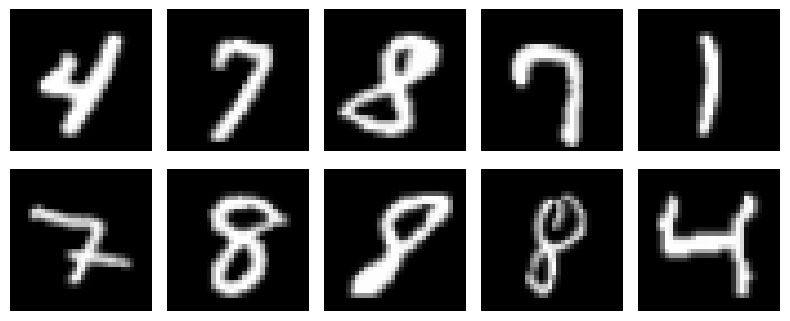

In [50]:
# Sample 10 unique indices from the index range of the dataset.
indices = random.sample(range(dataset_size), k=10)

rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(8, 3.5))
for i in range(len(indices)):
    row = i // cols
    col = i % cols
    axs[row][col].imshow(dataset[indices[i]][0].permute(1, 2, 0), cmap=plt.cm.gray)
    axs[row][col].axis('off')
plt.tight_layout()

## 2. Forward Diffusion

In [69]:
class Diffusion:

    def __init__(self, timestamps_max):

        self.timestamps_max = timestamps_max

        self._calculateAlphas()

    def _linear_beta_schedule(self, timestamps):
        r"""Generate betas for adding noise to images in a linear way.

        The returned value is a tensor of shape (timestamps,) and dtype torch.float32.
        """

        scale = 1000 / timestamps
        beta_start_scaled = 0.0001 * scale
        beta_end_scaled = 0.02 * scale
        return torch.linspace(start=beta_start_scaled, end=beta_end_scaled, steps=timestamps, device=DEVICE)
    
    def _calculateAlphas(self):
        """Calculate the variables related to alphas."""

        # self.betas is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.betas = self._linear_beta_schedule(self.timestamps_max)
        # self.alphas is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.alphas = 1 - self.betas
        # self.alphas_cumprod is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.alphas_cumprod = self.alphas.cumprod(dim=0)
        # self.sqrt_alphas_cumprod is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        # self.sqrt_one_minum_alphas_cumprod is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas).sqrt()

    def _constructAlphaTensor(self, src, t, num_dim):
        """Construct the alpha values or one minus alpha values for adding noise.

        Args:
            src (shape (self.timestamps_max,) & dtype torch.float32): self.sqrt_alphas_cumprod
                or self.sqrt_one_minus_alphas_cumprod.
            t (shape (BATCH_SIZE,) & dtype torch.int64): time representation.
            num_dim (int): number of dimensions in the images.
        """

        batch_size = t.size()[0]

        # alphas is a tensor of shape (batch_size,) and torch.float32.
        alphas = src.gather(dim=0, index=t)

        # Return a tensor of shape (batch_size, 1, 1, 1) and torch.float32.
        return alphas.reshape(batch_size, *((1,) * (num_dim-1)))

    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion.

        Args:
            x_start (shape (BATCH_SIZE, 3, HEIGHT, WIDTH) & dtype torch.float32): images to diffuse.
            t (shape (BATCH_SIZE,) & dtype torch.float32): time representation.
        """

        # Generate the noise.
        # noise is a tensor of shape (BATCH_SIZE, 3, HEIGHT, WIDTH) and dtype torch.float32.
        if noise == None:
            noise = torch.randn_like(x_start)

        # Generate the alpha values and one minus alpha value for adding noise.
        # sqrt_alphas_cumprod_t is a tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        sqrt_alphas_cumprod_t = self._constructAlphaTensor(self.sqrt_alphas_cumprod, t, len(x_start.shape))
        # sqrt_one_minus_alphas_cumprod_t is a tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        sqrt_one_minus_cumprod_t = self._constructAlphaTensor(self.sqrt_one_minus_alphas_cumprod, t, len(x_start.shape))
        
        # Return a tensor of shape (BATCH_SIZE, 3, HEIGHT, WIDTH) and dtype torch.float32.
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_cumprod_t * noise

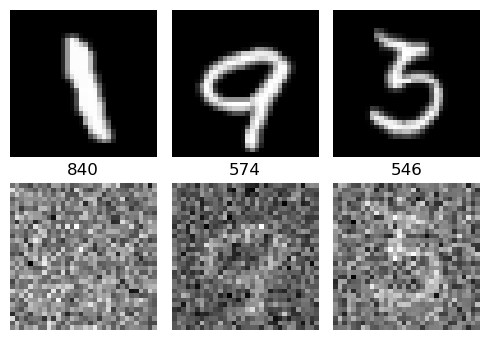

In [73]:
diffusion = Diffusion(TIMESTAMPS)

# t is a tensor of shape (BATCH_SIZE,) and dtype torch.int64.
t = torch.randint(0, TIMESTAMPS, (BATCH_SIZE,), device=DEVICE)

# Sample 5 images from the dataset.
# images is a tensor of shape (BATCH_SIZE, 3, 218, 178) and dtype torch.float32.
images = next(iter(dataloader))[0].to(DEVICE)

# Add noise to the images.
noisy_images = diffusion.q_sample(images, t)

# Show the noisy images.
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(5, 3.5))
for col in range(cols):
    axs[0][col].imshow(images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[0][col].axis('off')
for col in range(cols):
    axs[1][col].imshow(noisy_images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[1][col].axis('off')
    axs[1][col].set_title(t[col].item())
plt.tight_layout()

## 3. Model

Timestamp embedding.

In [75]:
def time_embedding(t, dim, period_max=10000.):
    """Calculate embedding for timestamps.

    Args:
        t (shape (BATCH_SIZE,) & dtype torch.int64): time representation.
        dim (int): dimension of the embedding.
        period_max(float): max period of sinusoidal and cosinoidal functions.
    """

    # batch_size is a Python int.
    batch_size = t.size()[0]

    # Calculate half of the embedding dimension.
    # half is a Python float.
    half = dim // 2

    # Calculate the parameter w that controls frequencies.
    # w is a tensor of shape (half,) and dtype torch.float32.
    w = torch.exp(
        -math.log(period_max) *
        torch.arange(start=0, end=half, dtype=torch.float32, device=DEVICE) / half
    )
    
    # args is the arguments of sinusoidal and cosinoidal functions.
    # args is a tensor of shape (batch_size, half) and dtype torch.float32.
    # t[:, None] is a tensor of shape (batch_size, 1) and dtype torch.int64.
    # w[None, :] is a tensor of shape (1, half) and dtype torch.float32.
    args = t[:, None].float() * w[None, :]
    
    # embedding is a tensor of shape (batch_size, half*2) and dtype torch.float32.
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

    # embedding is a tensor of shape (batch_size, dim) and dtype torch.float32.
    if dim % 2 != 0:
        embedding = torch.cat([embedding, torch.zeros(batch_size, 1)], dim=-1)

    return embedding

Define a module that accepts time embedding.

In [54]:
class EmbeddingBlock(torch.nn.Module, abc.ABC):
    """Any module where forward() takes timestep embeddings as
    a second argument.
    """

    @abc.abstractmethod
    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

Define a sequential module that contains EmbeddingBlock.

In [55]:
class EmbeddingSequential(torch.nn.Sequential, EmbeddingBlock):
    """A sequential module that contains EmbeddingBlock."""

    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

        for layer in self:
            if isinstance(layer, EmbeddingBlock):
                x = layer(x, embedding)
            else:
                x = layer(x)
        
        return x

Define the residual block.

In [56]:
class ResidualBlock(EmbeddingBlock):
    """Residual block that takes time embedding as an input."""

    def __init__(self, in_channels, out_channels, embedding_channels, dropout):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.GroupNorm(GROUP_NORM_GROUPS, in_channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
        )

        self.embedding = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(embedding_channels, out_channels),
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.GroupNorm(GROUP_NORM_GROUPS, out_channels),
            torch.nn.SiLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
        )

        if in_channels != out_channels:
            self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = torch.nn.Identity()

    def forward(self, x, embedding):
        """
        Args:
            x (shape (BATCH_SIZE, in_channels, height, width) & dtype torch.float32)
            embedding (shape (BATCH_SIZE, dim) & dtype torch.float32)
        """

        out = self.conv1(x)
        out += self.embedding(embedding)[:, :, None, None]
        out = self.conv2(out)
        return out + self.shortcut(x)

Define the attention block.

In [57]:
class AttentionBlock(torch.nn.Module):
    """Attention block."""

    def __init__(self, channels, heads=1):
        super().__init__()

        self.heads = heads
        assert channels % heads == 0

        self.gn = torch.nn.GroupNorm(GROUP_NORM_GROUPS, channels)
        self.qkv = torch.nn.Conv2d(channels, channels*3, kernel_size=1, bias=False)
        self.proj = torch.nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):

        batch_size, channels, height, width = x.size()

        # qkv is a tensor of shape (batch_size, channels*3, height, width)
        qkv = self.qkv(self.gn(x))
        # q, k, v are tensors of shape (batch_size, channels, height, width)
        q, k, v = qkv.reshape(batch_size*self.heads, -1, height*width).chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(channels // self.heads))
        attn = torch.einsum('bct,bcs->bts', q*scale, k*scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum('bts,bcs->bct', attn, v)
        h = h.reshape(batch_size, -1, height, width)
        h = self.proj(h)

        return h + x

Define a downsampler class.

In [58]:
class Downsampler(torch.nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):

        return self.conv(x)

Define an upsampler class.

In [59]:
class Upsampler(torch.nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, padding='same')

    def forward(self, x):

        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv(x)

        return x

Construct the model.

In [60]:
class Model(torch.nn.Module):

    def __init__(
        self,
        in_channels=CHANNELS,
        out_channels=CHANNELS,
        model_channels = 128,
        channel_mult = (1, 2, 2, 2),
        res_blocks = 2,
        dropout=0,
        attention_resolutions = (8, 16),
        heads=4,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.model_channels = model_channels

        # Construct layers.

        # Variable to control layers and channels.
        ds = 1
        channels = model_channels

        # Time embedding.
        embedding_dim = model_channels * 4
        self.embed = torch.nn.Sequential(
            torch.nn.Linear(model_channels, embedding_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(embedding_dim, embedding_dim)
        )

        # Downsampling blocks.
        self.down_blocks = torch.nn.ModuleList([
            EmbeddingSequential(torch.nn.Conv2d(in_channels, model_channels, kernel_size=3, padding='same'))
        ])
        down_block_channels = [model_channels]
        for level, mult in enumerate(channel_mult):
            for _ in range(res_blocks):
                layers = [
                    ResidualBlock(channels, model_channels*mult, embedding_dim, dropout),
                ]
                channels = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(channels, heads=heads))
                self.down_blocks.append(EmbeddingSequential(*layers))
                down_block_channels.append(channels)
            if level != len(channel_mult)-1:
                self.down_blocks.append(EmbeddingSequential(Downsampler(channels)))
                down_block_channels.append(channels)
                ds *= 2

        # Middle block.
        self.middle_block = EmbeddingSequential(
            ResidualBlock(channels, channels, embedding_dim, dropout),
            AttentionBlock(channels, heads=heads),
            ResidualBlock(channels, channels, embedding_dim, dropout),
        )

        # Upsampling blocks.
        self.up_blocks = torch.nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(res_blocks+1):
                layers = [
                    ResidualBlock(channels+down_block_channels.pop(), model_channels*mult, embedding_dim, dropout),
                ]
                channels = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(channels, heads=heads))
                if level > 0 and i == res_blocks:
                    layers.append(Upsampler(channels))
                    ds //= 2
                self.up_blocks.append(EmbeddingSequential(*layers))

        # Output block.
        self.out = torch.nn.Sequential(
            torch.nn.GroupNorm(GROUP_NORM_GROUPS, channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(model_channels, out_channels, kernel_size=3, padding='same')
        )

    def forward(self, x_t, t):
        """
        Args:
            x_t (shape (BATCH_SIZE, 3, HEIGHT, WIDTH) & dtype torch.float32): noisy images.
            t (shape (BATCH_SIZE,) & dtype torch.int64): time representation.
        """

        out = x_t
        outs = []

        # embedding is a tensor of shape (BATCH_SIZE, self.model_channels*4) and dtype torch.float32.
        embedding = self.embed(time_embedding(t, self.model_channels))

        # Downsampling stage.
        for module in self.down_blocks:
            out = module(out, embedding)
            outs.append(out)

        # Middle stage.
        out = self.middle_block(out, embedding)

        # Upsampling stage.
        for module in self.up_blocks:
            out = module(torch.cat([out, outs.pop()], dim=1), embedding)

        return self.out(out)

## 4. Training

Define a function to train one epoch.

In [66]:
def trainOneEpoch(model, dataloader, diffusion, optimizer, loss_fn):
    """Train the model for one epoch."""

    for _, [images, _] in enumerate(dataloader):
        # Move data to the proper device.
        images = images.to(DEVICE)

        # Generate noise and predicted noise
        noise = torch.randn_like(images, device=DEVICE)
        t = torch.randint(0, TIMESTAMPS, (BATCH_SIZE,), device=DEVICE)
        noisy_images = diffusion.q_sample(images, t, noise)
        noise_predicted = model(noisy_images, t)

        # Reset gradients.
        optimizer.zero_grad()

        # Calculate loss and gradients.
        loss = loss_fn(noise, noise_predicted)
        print(loss)
        loss.backward()
        optimizer.step()

In [ ]:
model = Model().to(DEVICE)
diffusion = Diffusion(TIMESTAMPS)
optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

trainOneEpoch(model, dataloader, diffusion, optimizer, loss_fn)

## References

[1] Jonathan Ho, Ajay Jain and Pieter Abbeel. Denoising Diffusion Probabilistic Models. arXiv, 2020.